# Saturated Growth model
$$ u' = u(C-u) $$
where $C=1$

Ref:
* Author: Tirtho Sarathi Saha (t.saha@tu-bs.de)

Kernel: ```sciann```

In [1]:
import sciann as sn

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)] 



In [2]:
# sciann doesn't work with the newer virsion of python and tensorflow. Worked with python.version=3.7.16, didn't work with 3.10./3.11. Try with other's later.
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 
import scipy.io
import csv

# zusätzliche Packages für das Lösen der DGL
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout

style = {'description_width': '100px'}
slider_layout = Layout(width='79%')

# SciANN Overview

SciANN is a Python library for scientific machine learning that allows you to build neural network models for solving scientific problems, including ordinary and partial differential equations (ODEs and PDEs). SciANN provides a range of classes and tools to help you define and solve scientific problems with neural networks.

## Key Components and Classes

### `sn.Variable`
- Class to define inputs to the network.

### `sn.Field`
- Class to define outputs of the network.

### `sn.Functional`
- Class to construct a nonlinear neural network approximation.

### `sn.Parameter`
- Class to define a parameter for inversion purposes.

### `sn.Data` and `sn.Tie`
- `sn.Data` is used to define the targets when there are observations for any variable.
- `sn.Tie` is used for physical constraints, such as PDEs or equality relations between different variables.

### `sn.SciModel`
- Class to set up the optimization problem, including inputs to the networks, targets (objectives), and the loss function.

### `sn.math`
- Module for mathematical operations, including functions and operations used in defining scientific problems.
- Supports operator overloading, which improves readability when setting up complex mathematical relations, such as PDEs.


Analytical sol'n

In [3]:
def ode_model(u, t, C):
    return u*(C-u)

def ode_solver(t, initial_cond, params):
    initu = initial_cond
    C = params
    res = odeint(ode_model, initu, t, args=(C,))
    return res

def solveDE(initu, C, tend):
    initial_cond = [initu]
    params = [C]
    tspan = np.arange(0, tend, 0.1)
    sol = ode_solver(tspan, initial_cond, params)
    u = sol[:,0]
    plt.plot(tspan, u)
    plt.show()

In [14]:
# Result collector
MSEC = []
Cs =[]

Create training Data

In [5]:
initial_cond = [0.01] # u_0
params = [1] # C
tTrain = np.linspace(0,20,500)
sol = ode_solver(tTrain, initial_cond, params)
uTrain = sol[:,0]

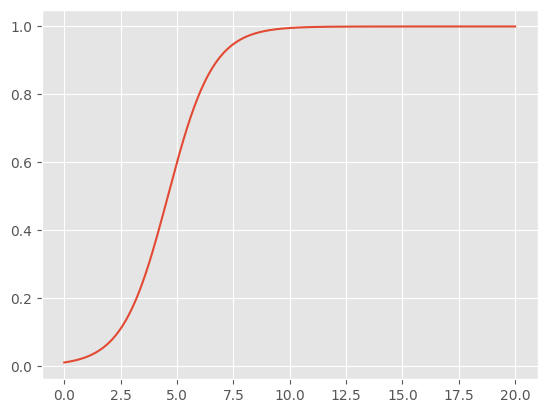

In [6]:
plt.plot(tTrain, uTrain)

Let's tak e more sparse and less data for training:

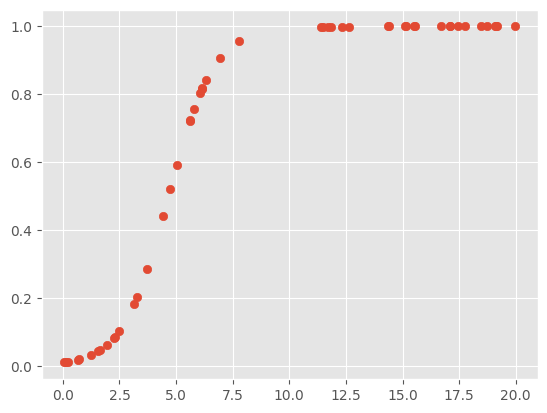

In [7]:
tTrain_sparse = np.sort(np.random.uniform(0,20,50))
sol_sparse = ode_solver(tTrain_sparse, initial_cond, params) # Lösen der DGL
uTrain_sparse = sol_sparse[:, 0]
plt.scatter(tTrain_sparse, uTrain_sparse)

In [23]:
# Add small random noise
noise_level = 0.05  # You can adjust this to control the noise level
noise = np.random.normal(0, noise_level, uTrain_sparse.shape)
noisy_data = uTrain_sparse + noise
noisy_data

array([-0.03215731, -0.04094854, -0.04371991,  0.03905243, -0.05055348,
       -0.08524291,  0.0658357 ,  0.10988462,  0.07626129,  0.09408139,
        0.09095535,  0.10531606,  0.16459945,  0.2273559 ,  0.29465712,
        0.47030702,  0.62289964,  0.59507389,  0.78396322,  0.66391384,
        0.71748709,  0.8250364 ,  0.74272976,  0.72912345,  0.77446926,
        0.9428146 ,  0.89765358,  0.92257383,  1.03453204,  0.96318755,
        0.97066435,  1.03943762,  0.99463052,  0.94142297,  1.01393337,
        1.01706596,  0.97603261,  1.01397368,  0.98378384,  0.89507887,
        1.0830885 ,  1.04306236,  1.02903362,  1.0238731 ,  1.03265703,
        0.978037  ,  0.95725287,  1.01932363,  1.07589992,  0.90818364])

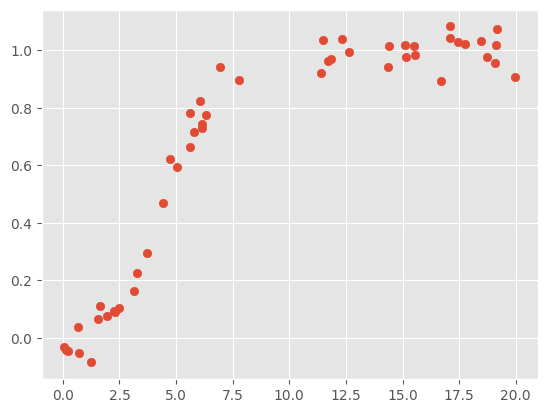

In [24]:
plt.scatter(tTrain_sparse, noisy_data)

Create SciANN model

In [12]:
# Model Input
t = sn.Variable("t", dtype='float64')

# NN model architecture
u = sn.Functional("u", t, 3*[5], 'tanh')



$$ NN1$$
Saturated growth model's fixed parameter
$$C = 1$$

In [11]:
# initialize the target parameters
C = sn.Parameter(0.5, inputs=t, name="C")

# set up PINN-model
u_t = sn.diff(u,t)

# Define data constraints
d1 = sn.Data(u)

# define model constraints
c1 = sn.Tie(u_t, u*(C-u))

# set the model
model = sn.SciModel(t, [d1, c1]) # https://www.sciann.com/scimodels/#scimodel

Train the Model

In [25]:
# Model input
input_data = [tTrain_sparse] # tTrain, tTrain_sparse
# Constraints
data_d1 = noisy_data #u uTrain, uTrain_sparse
data_c1 = 'zeros'
# Model output 
target_data = [data_d1, data_c1]

# Train
history = model.train(x_true=input_data,
                      y_true=target_data,
                      epochs=500,
                      batch_size=25,
                      shuffle=True,
                      learning_rate=0.001,
                      reduce_lr_after=100,
                      stop_loss_value=1e-8,
                      verbose=1)


Total samples: 50 
Batch size: 25 
Total batches: 2 

Epoch 1/500
2/2 [==============================] - 0s 1ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.0029 - u_loss: 0.0029 - sub_2_loss: 3.7082e-05 - lr: 0.0010 - time: 0.0040
Epoch 2/500
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.0026 - u_loss: 0.0026 - sub_2_loss: 4.2123e-05 - lr: 0.0010 - time: 0.1050
Epoch 3/500
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.0027 - u_loss: 0.0027 - sub_2_loss: 3.9715e-05 - lr: 0.0010 - time: 0.1067
Epoch 4/500
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.0027 - u_loss: 0.0025 - sub_2_loss: 1.5680e-04 - lr: 0.0010 - time: 0.1077
Epoch 5/500
2/2 [==============================] - 0s 3ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.0027 - u_loss: 0.0024 - sub_2_loss: 2.4013e-04 - lr: 0.0010 - time: 0.1052
Epoch 6/500
2/2 [============================

In [26]:
print("C: {}".format(C.value))

C: [0.98886016]
